## Packages
Install necessary packages: numpy, control, and multiprocessing.

In [1]:
%%capture
!pip install numpy control multiprocess matplotlib ipympl -U

In [2]:
# Import necessary packages
from typing import (
    Callable
)

import re

import numpy as np
import control as ct

from multiprocess import Pool

%matplotlib ipympl
import matplotlib.pyplot as plt

## Plot
Given a transfer function **H**, frequency range **\[start, end\]**, and propagation delay **delay**, we numerically approximate the transfer function given a square wave amplifier, which theoretically produces an infinite number of harmonics. If there is no propagation delay or it is already approximated in the transfer function, **delay** defaults to the floating point ε to approximate the limit form mentioned in Putzey's paper.

In [3]:
def plot(
    H: ct.TransferFunction, 
    start: float, 
    end: float, 
    delay=np.finfo(np.longdouble).eps
) -> None:
    """ Takes a SISO transfer function `H` and plots phase response and loop gain vs.
    frequency, oscillation frequency vs. duty cycle, DC transfer curve, and loop gain 
    vs. duty cycle. """

    # Range of frequencies
    omega = np.logspace(
        np.log10(start),
        np.log10(end),
        num=5_000,
        dtype=np.longdouble
    )
    
    # Range of duty cycles
    hs = np.linspace(0.1, 0.5, num=1_000, dtype=np.longdouble)

    with Pool() as p:
        # Range of harmonics to calculate
        ns = np.arange(1., 1_000., dtype=np.longdouble)
        
        # Avoid extra computation of Hz -> Rad/s constant
        rad = np.clongdouble(2j * np.pi)
            
        fs = np.fromiter(
            p.imap(
                lambda n: H(f := rad * n * omega) * np.exp(-delay * f), 
                ns, chunksize=ns.size // p._processes
            ),
            dtype=np.dtype((np.clongdouble,omega.size)),
            count=ns.size
        )

        def g(h: np.longdouble) -> np.ndarray:
            # Tmp variables to avoid double computation
            tmp = np.exp(rad * ns * h)
            tmp2 = (1 - (1 / tmp)) / (2 * ns)
            tmp3 = (1 - tmp) * tmp2

            # Calculate frequency response
            fr = np.einsum('a,ab->b', tmp3, fs)

            # Decompose frequency response
            mag = np.absolute(fr)
            ph = np.unwrap(np.angle(fr))
        
            # Identify falling zero-crossings of phase (inverting power stage adds pi phase shift)
            g = ph > -np.pi
            zc = g[:-1] & ~g[1:]
            ind = zc.size - np.argmax(np.flip(zc)) - 1

            # Binary search for exact zero-crossing frequency (within eps)
            start = omega[ind]
            end = omega[ind+1]
            p_err = np.nan

            max_iters = 100
            iters = 0
            while not np.isclose(p_err, -np.pi, rtol=1e-15, atol=1e-11):
                if iters > max_iters:
                    raise ValueError(f'Binary search did not converge in {max_iters} iterations, err={p_err}')
                # Guaranteed to run once and set mid because p_err == nan
                mid = (start + end) / 2

                tmp4 = H(f := rad * ns * mid) * np.exp(-delay * f)
                p_err = np.angle(tmp3 @ tmp4)

                if p_err > 0: end = mid
                else: start = mid

                iters += 1

            # Calculate dcin
            dcin = np.real((-tmp2 / 1j) @ tmp4) * (4 / np.pi)
            
            return mag, ph, mid, dcin
            

        res = np.fromiter(
            p.imap(g, hs, chunksize=hs.size // p._processes),
            dtype=np.dtype([
                ('mag', np.dtype((np.longdouble, omega.size))),
                ('ph', np.dtype((np.longdouble, omega.size))),
                ('osc_f', np.longdouble),
                ('dcin', np.longdouble)
            ]),
            count=hs.size
        )
        mags, phs, osc_fs, dcins = map(res.__getitem__, res.dtype.names)

        dcgains = np.gradient(hs * 2 - 1, -dcins)
    
    # Plotting
    fig, ((ax_ph, ax_dcgain), (ax_osc, ax_dcin)) = plt.subplots(2,2)

    # Set figure labels
    ax_osc.set_ylabel('Osc. Freq. (Hz)')
    ax_osc.set_xlabel('Duty Cycle')

    ax_ph.set_xlabel('Frequency (Hz)')
    ax_ph.set_ylabel('Phase (°)')
    ax_mag = ax_ph.twinx()
    ax_mag.set_ylabel('Magnitude (dB)')

    # Plot phase
    cs = ['b','g','c','y']
    for i, p in enumerate(phs[-1:0:-(hs.size // 5),:]):
        ax_ph.plot(omega, np.degrees(np.unwrap(p)), f'{cs[i % len(cs)]}--')

    ax_ph.plot([start, end], [-180, -180], 'k:')
    ax_ph.set_xscale('log')

    max_ph = max(np.ceil(np.degrees(np.max(phs))), 0) + 10
    ax_ph.set_yticks([0, -180, -360])
    ax_ph.set_ylim(-360-max_ph, max_ph)

    # Plot oscillation frequencies
    ax_osc.plot(
        np.concatenate((hs, 1-hs[-1::-1])),
        np.concatenate((osc_fs, osc_fs[-1::-1]))
    )

    # Plot dcin
    ax_dcin.plot(
        np.concatenate((-dcins, dcins[-1::-1])),
        np.concatenate((hs, 1-hs[-1::-1]))
    )

    # Plot dcgain
    ax_dcgain.plot(
        np.concatenate((hs, 1-hs[-1::-1])),
        np.concatenate((dcgains, dcgains[-1::-1]))
    )

    # Plot magnitude
    mag_scaled = 20 * np.log10(dcgains[-1] * np.absolute(fs[0]))
    ax_mag.plot(omega, mag_scaled, 'r-')

    max_mag = round(max(
        *map(
            np.abs, 
            (np.min(mag_scaled), np.max(mag_scaled))
        ), 
        0
    )) + 3
    ax_mag.set_ylim(-max_mag, max_mag)

    fig.tight_layout()



## Transfer Functions

As per Bruno Putzey's 2011 paper titled ["Global Modulated Self-Oscillating Amplifier with Improved Linearity"](https://www.hypex.nl/media/3f/62/4a/1682342035/Globally%20modulated%20self-oscillating%20amplifier.pdf), we treat our Class-D amplifier as a square wave oscillator wrapped with a linear function. For simplicity's sake, we further split said linear function into three serial sections–the **propagation delay**, **low pass filter**, and **feedback network**. The **propagation delay** is calculated during numerical evaluation in order to avoid using a Padé approximation. Please define functions constructing transfer functions based on component values for the **low pass filter** and **feedback network** below.

In [4]:
def lpf(L: float, C: float, R_load: float) -> ct.TransferFunction:
    """ Function representing a common 2nd order output filter for Class-D amplifiers.
    Returns a transfer function per the corresponding values
    """
    s = ct.tf('s')

    return R_load / (R_load * L * C * s**2 + L * s + R_load)

def fbn_example(R_in, C_in, R_lead, C_lead, R_fb, R_sep) -> ct.TransferFunction:
    s = ct.tf('s')

    b = R_lead + 1 / (C_lead * s)

    a = b + R_sep

    H_n = R_in * (a + R_fb) / (R_fb * a + R_in * a + R_fb *  R_in * a * C_in * s + R_fb * R_in)

    H = (R_sep + H_n * b) / (R_sep + b)

    return H

In [5]:
def load_sapwin(filename: str) -> Callable[[],ct.TransferFunction]:
    """ Parses a SapWin output file into a function that takes in component values and 
    outputs a transfer function. Allows offloading of the symbolic analysis of feedback
    networks for faster prototyping.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()[2:]

    all_vars = set()
    num_exprs = list()
    den_exprs = list()

    lst = num_exprs
    ord_count = 0
    
    for l in lines:
        if l == '\n':
            break
        if set(l[:-1]) == {'-'}:
            ord_count = 0
            lst = den_exprs
            continue

        expr = ""
        
        parens = re.search('\(.*\)', l)
        coef = parens.group()[1:-1]
        terms = re.findall('\S+', coef)
        varss = set(re.findall('\w+', coef))
        
        tail = l[parens.span()[-1]:]
        if lap := re.search('s(\^\d+)?', tail):
            tmp = re.search('\d+', lap.group())
            ordr = int(tmp.group()) if tmp else 1
        else: ordr = 0

        all_vars.update(varss)

        prev_var = False
        for t in terms:
            if t in varss:
                if prev_var:
                    expr += "*"
                prev_var = True
                expr += f"{{{t}}}"
                continue
            expr += t
            prev_var = False
        
        while ordr < ord_count:
            lst.append(0)
            ord_count += 1

        lst.append(expr)
        ord_count += 1
        
    def func(**kwargs):
        if(kwargs.keys() < all_vars):
            print(all_vars.difference(kwargs.keys()))
            raise ValueError(f"Missing {str(all_vars.difference(kwargs.keys()))}")

        def eval_coef(lst):
            return list(map(lambda e: eval(e.format(**kwargs)), reversed(lst)))

        num, den = map(eval_coef, (num_exprs, den_exprs))
        return ct.tf(num, den)

    return func

## Workspace

<TransferFunction>: sys[4551]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


2 s^4 + 1.257e+07 s^3 + 2.961e+13 s^2 + 3.101e+19 s + 1.218e+25
---------------------------------------------------------------
 s^4 + 8.011e+06 s^3 + 2.406e+13 s^2 + 3.21e+19 s + 1.605e+25

<TransferFunction>: sys[4550]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                          6.088e+20
-------------------------------------------------------------
s^4 + 3.513e+05 s^3 + 7.402e+10 s^2 + 8.667e+15 s + 6.088e+20

<TransferFunction>: sys[4545]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


            4
--------------------------
3.12e-10 s^2 + 2e-05 s + 4

<TransferFunction>: sys[4553]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


               8 s^8 + 5.308e+07 s^7 + 1.367e+14 s^6 + 1.694e+20 s^5 + 1.015e+26 s^4 + 2.736e+31 s^3 + 4.811e+36 s^2 + 5.758e+41 s + 6.874e+46
----------------------------------------------------------------------------------------------------------------------------------------

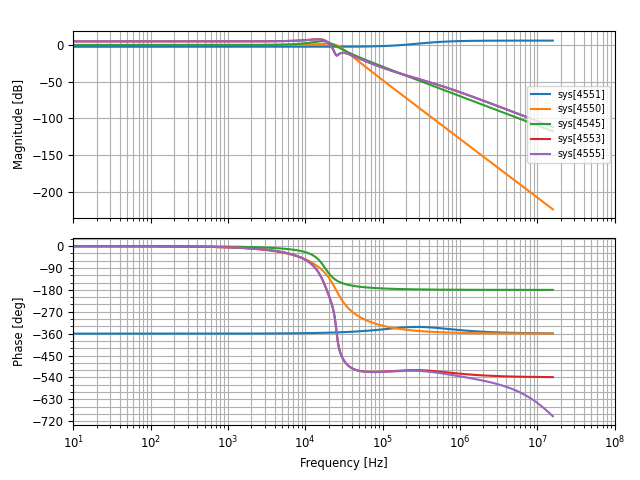

In [198]:
out = lpf(20e-6, 3.9e-6, 4)


iff = 25e3*2*np.pi

i = 1
#for fsf, q in [(1.6060, 0.5103), (1.6913, 0.6112), (1.9071, 1.0234)]:
#for fsf, q in [(0.3532, 0.7608), (0.7468, 2.1977), (0.9953, 8.0012)]:
#for fsf, q in [(1.000, 0.5177), (1.000, 0.7071), (1.000, 1.9320)]:
for fsf, q in [(1.000, 0.6180), (1.000, 1.6181)]:
    sf = iff * fsf
    i *= ct.tf([sf**2], [1, sf*fsf/q, sf**2])

compf = 10*iff
compr = [1.2, 1.3, 1.3, 1.3]
comp = ct.zpk([-compf-1j, -compf+1j] * 2, [-r * compf for r in compr], 2e5)

fbn = out * (comp + i)

delay = 30e-9

plt.clf()

plot_kwargs = {'Hz': True, 'dB': True, 'omega_limits': (10, 100e6)}
for tf in (comp, i, out, fbn, fbn * ct.tf(*ct.pade(delay, n=2))):
    print(tf)
    ct.bode_plot(tf, **plot_kwargs)

plt.show()

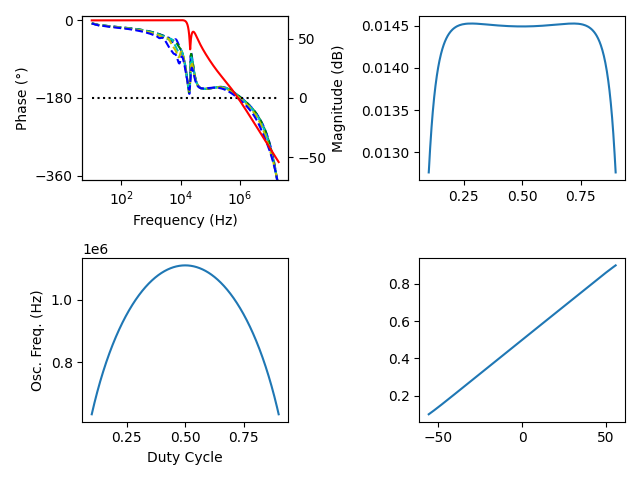

CPU times: user 1.81 s, sys: 1.41 s, total: 3.22 s
Wall time: 10.9 s


In [195]:
%%time
plot(fbn, 10, 20e6, delay=delay)
plt.show()

In [174]:
def disp(lst):
    return np.array(lst).flatten()

max_gain = 1

for tf in (comp, i, out):
    tf /= max_gain
    print(tf)
    print(*map(disp, (tf.num, tf.den)))

<TransferFunction>: sys[3935]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


4 s^4 + 2.513e+07 s^3 + 5.922e+13 s^2 + 6.201e+19 s + 2.435e+25
---------------------------------------------------------------
 s^4 + 8.011e+06 s^3 + 2.406e+13 s^2 + 3.21e+19 s + 1.605e+25

[4.00000000e+00 2.51327412e+07 5.92176264e+13 6.20125534e+19
 2.43522728e+25] [1.00000000e+00 8.01106127e+06 2.40571607e+13 3.20953721e+19
 1.60505830e+25]
<TransferFunction>: sys[3937]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                   6.088e+15 s + 9.563e+20
-------------------------------------------------------------
s^4 + 3.513e+05 s^3 + 7.402e+10 s^2 + 8.667e+15 s + 6.088e+20

[6.08806819e+15 9.56311515e+20] [1.00000000e+00 3.51250754e+05 7.40223834e+10 8.66676498e+15
 6.08806819e+20]
<TransferFunction>: sys[3939]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


            4
--------------------------
3.12e-10 s^2 + 2e-05 s + 4

[4] [3.12e-10 2.00e-05 4.00e+00]
